## Introduction

In this assignment, you are expected to apply feature engineering techniques to a
football-related dataset to analyze the likelihood of scoring a goal through a shot. Next, you
will delve into regression and cross-validation concepts further by implementing multivariate
regression and k-fold cross-validation from scratch and utilize them on a preprocessed
dataset related to cars. Lastly, you will compare your outcomes with those attained using
Python's built-in libraries. This task will strengthen your comprehension of these concepts
and their practical implementation.

# Dataset

The dataset you’ll use for the preprocessing part pertains to football data (football.csv). It
includes information about shots such as the timing, location (corner, penalty, etc.), and the
outcome of the shots (saved by the keeper, blocked by defenders, missed, etc). Uncovering
more intriguing facts about this dataset is up to you :)
For the implementation parts, you’ll use a completely different, preprocessed dataset that
contains information about cars (cars.csv). You should use this dataset to train your custom
multivariate regression and k-fold models to predict the “Price in Thousands” and
“Horsepower” columns.

# Tasks



1. **Preprocessing**

You are tasked with cleaning and analyzing the dataset, highlighting its statistical
attributes and visualizing its features. Your goal is to identify the beneficial features
and justify your conclusions convincingly. Additionally, you should employ feature
engineering techniques to refine the dataset, either by removing or replacing less
desirable features. To gain a deeper understanding of feature engineering, it is
recommended to train an arbitrary but appropriate model and evaluate the outcomes
before and after preprocessing. Furthermore, to assess the importance of each
feature, utilize the mutual information method to create a pandas dataframe with two
columns: one for features and the other for their importance. Subsequently, sort the
dataframe in descending order based on importance and display the results.

- You can apply various methods that you have learned throughout the course to
fill missing values and manipulate categorical features in your data.
- You can consolidate similar features. For instance, you could treat "goal" and
"own goal" as the same.
- Employ feature selection to exclude less significant features, thereby reducing
the dimensionality and lowering computational costs.
- For a more thorough analysis, consider extracting new, more informative
features from existing ones. For instance, calculate shot distance and angle
using the following formulas and incorporate them into your analysis:

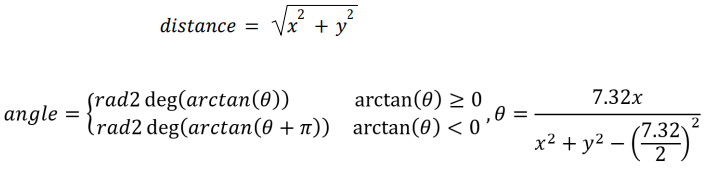

In [2]:
from PIL import Image
import IPython.display as display

img = Image.open('5.png') 
display.display(img)

In [78]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, learning_curve
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelEncoder

In [7]:
raw_data = pd.read_csv("football.csv")

In [8]:
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8925 entries, 0 to 8924
Data columns (total 12 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   matchId                8925 non-null   object 
 1   playerId               8925 non-null   object 
 2   playType               8925 non-null   object 
 3   bodyPart               8925 non-null   object 
 4   x                      8925 non-null   float64
 5   y                      8925 non-null   float64
 6   interveningOpponents   8925 non-null   int64  
 7   interveningTeammates   8925 non-null   int64  
 8   interferenceOnShooter  8891 non-null   object 
 9   minute                 8925 non-null   int64  
 10  second                 8925 non-null   int64  
 11  outcome                8891 non-null   object 
dtypes: float64(2), int64(4), object(6)
memory usage: 836.8+ KB


In [9]:
raw_data.describe()

,x,y,interveningOpponents,interveningTeammates,minute,second
count,8925.000000,8925.000000,8925.000000,8925.000000,8925.000000,8925.000000
mean,14.564631,0.364408,2.531989,0.336471,48.541401,29.243810
std,7.841865,8.999063,1.386693,0.680175,26.397998,17.306565
min,0.000000,-33.920000,0.000000,0.000000,0.000000,0.000000
25%,8.480000,-5.740000,2.000000,0.000000,26.000000,14.000000
50%,12.470000,0.500000,2.000000,0.000000,49.000000,29.000000
75%,20.950000,6.730000,3.000000,0.000000,71.000000,44.000000
max,70.820000,33.920000,11.000000,7.000000,98.000000,59.000000


In [10]:
raw_data.head()

,matchId,playerId,playType,bodyPart,x,y,interveningOpponents,interveningTeammates,interferenceOnShooter,minute,second,outcome
0,m_91,p_103,open play,right foot,13.47,-11.22,1,0,medium,70,9,goal
1,m_17,p_16,open play,left foot,9.48,14.22,3,0,medium,55,4,saved by keeper
2,m_111,p_88,free kick,left foot,29.43,-1.25,6,2,low,86,31,saved by keeper
3,m_142,p_87,open play,right foot,26.93,1.00,4,1,medium,77,2,missed chance
4,m_117,p_9,open play,right foot,10.72,5.24,2,0,medium,76,46,goal


In [11]:
for column in raw_data.columns:
		if len(raw_data[column].unique()) < 10:
				print(f"\033[94m{column}\033[0m")
				print(raw_data[column].unique())
				print()

playType
['open play' 'free kick' 'penalty' 'olimpico']

bodyPart
['right foot' 'left foot' 'head' 'other']

interveningTeammates
[0 2 1 3 4 5 7]

interferenceOnShooter
['medium' 'low' 'high' nan]

outcome
['goal' 'saved by keeper' 'missed chance' 'blocked shot' 'hit the post'
 nan]



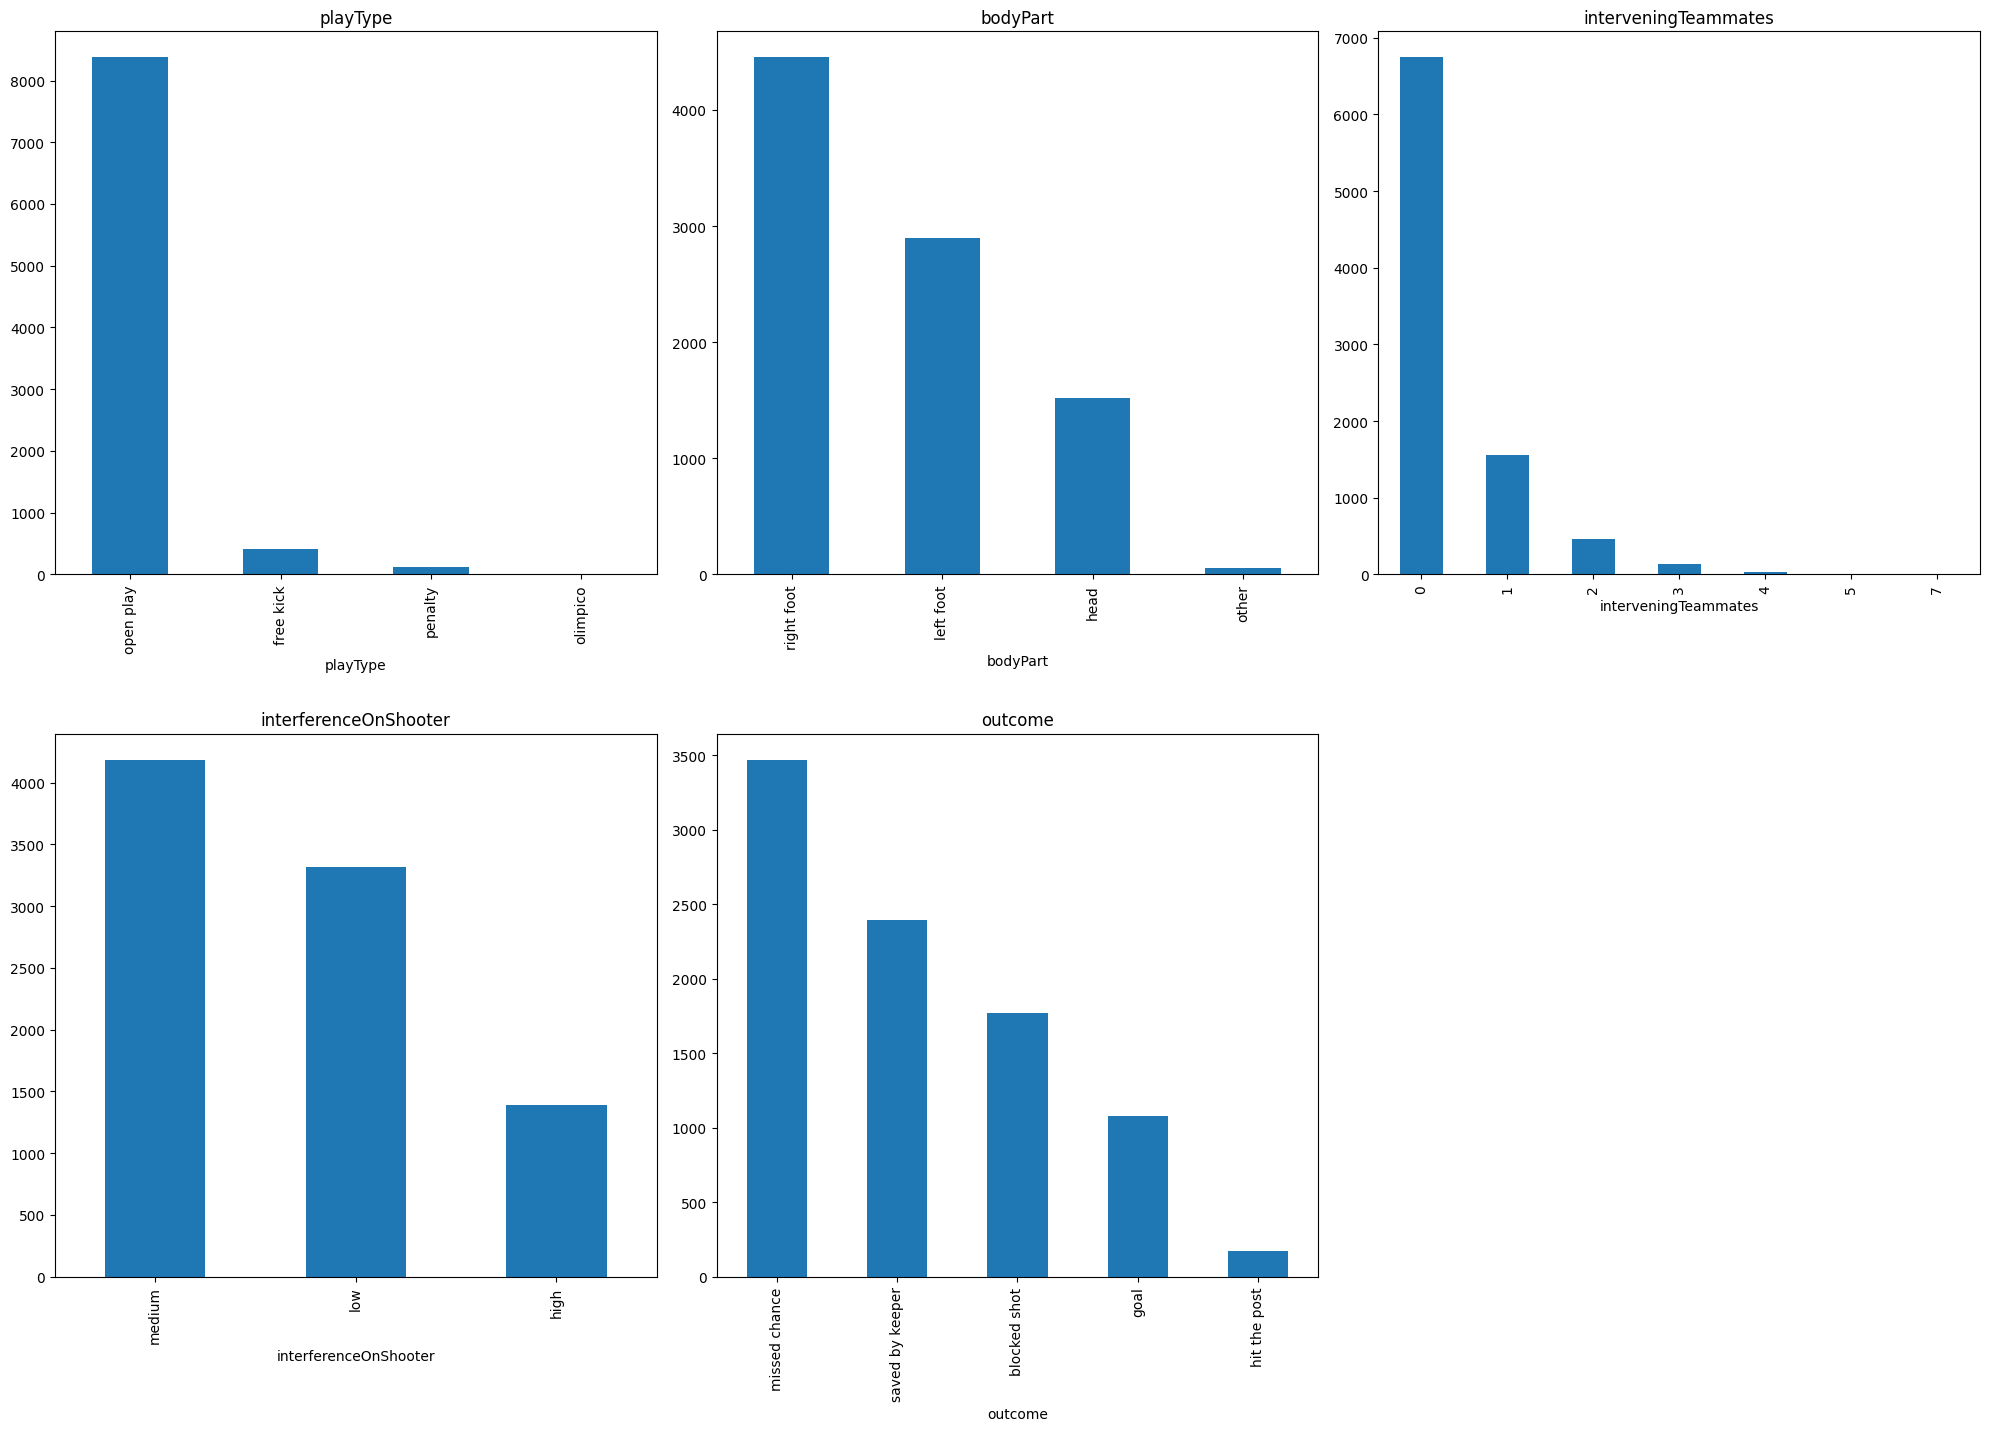

In [187]:
plt.figure(figsize=(20, 20))
j = 0
for column in raw_data.columns:
		if len(raw_data[column].unique()) < 10:
				j += 1
				plt.subplot(3, 3, j)
				raw_data[column].value_counts().plot(kind='bar')
				plt.title(column)

plt.tight_layout()
plt.show()



## Preprocessing the data

In [188]:
raw_data.isnull().sum()


matchId                   0
playerId                  0
playType                  0
bodyPart                  0
x                         0
y                         0
interveningOpponents      0
interveningTeammates      0
interferenceOnShooter    34
minute                    0
second                    0
outcome                  34
dtype: int64

In [189]:
print(raw_data.duplicated().sum())

0


In [190]:
clean_data = raw_data.dropna()
clean_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8891 entries, 0 to 8924
Data columns (total 12 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   matchId                8891 non-null   object 
 1   playerId               8891 non-null   object 
 2   playType               8891 non-null   object 
 3   bodyPart               8891 non-null   object 
 4   x                      8891 non-null   float64
 5   y                      8891 non-null   float64
 6   interveningOpponents   8891 non-null   int64  
 7   interveningTeammates   8891 non-null   int64  
 8   interferenceOnShooter  8891 non-null   object 
 9   minute                 8891 non-null   int64  
 10  second                 8891 non-null   int64  
 11  outcome                8891 non-null   object 
dtypes: float64(2), int64(4), object(6)
memory usage: 903.0+ KB


In [191]:
clean_data = clean_data.drop(columns=['matchId', 'playerId'])
clean_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8891 entries, 0 to 8924
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   playType               8891 non-null   object 
 1   bodyPart               8891 non-null   object 
 2   x                      8891 non-null   float64
 3   y                      8891 non-null   float64
 4   interveningOpponents   8891 non-null   int64  
 5   interveningTeammates   8891 non-null   int64  
 6   interferenceOnShooter  8891 non-null   object 
 7   minute                 8891 non-null   int64  
 8   second                 8891 non-null   int64  
 9   outcome                8891 non-null   object 
dtypes: float64(2), int64(4), object(4)
memory usage: 764.1+ KB


In [192]:
le = LabelEncoder()
clean_data['playType'] = le.fit_transform(clean_data['playType'])
clean_data['bodyPart'] = le.fit_transform(clean_data['bodyPart'])
clean_data['interferenceOnShooter'] = le.fit_transform(clean_data['interferenceOnShooter'])
# clean_data['outcome'] = le.fit_transform(clean_data['outcome'])
# if outcome was goal, then 1, else 0
clean_data['outcome'] = clean_data['outcome'].apply(lambda x: 1 if x == 'goal' else 0)
clean_data

,playType,bodyPart,x,y,interveningOpponents,interveningTeammates,interferenceOnShooter,minute,second,outcome
0,2,3,13.47,-11.22,1,0,2,70,9,1
1,2,1,9.48,14.22,3,0,2,55,4,0
2,0,1,29.43,-1.25,6,2,1,86,31,0
3,2,3,26.93,1.00,4,1,2,77,2,0
4,2,3,10.72,5.24,2,0,2,76,46,1
...,...,...,...,...,...,...,...,...,...,...
8920,2,0,6.48,3.99,3,0,0,69,50,0
8921,2,3,21.45,-8.73,4,1,2,15,53,0
8922,2,1,11.97,3.24,3,0,2,84,34,0
8923,2,3,6.48,-6.98,1,0,0,4,39,0


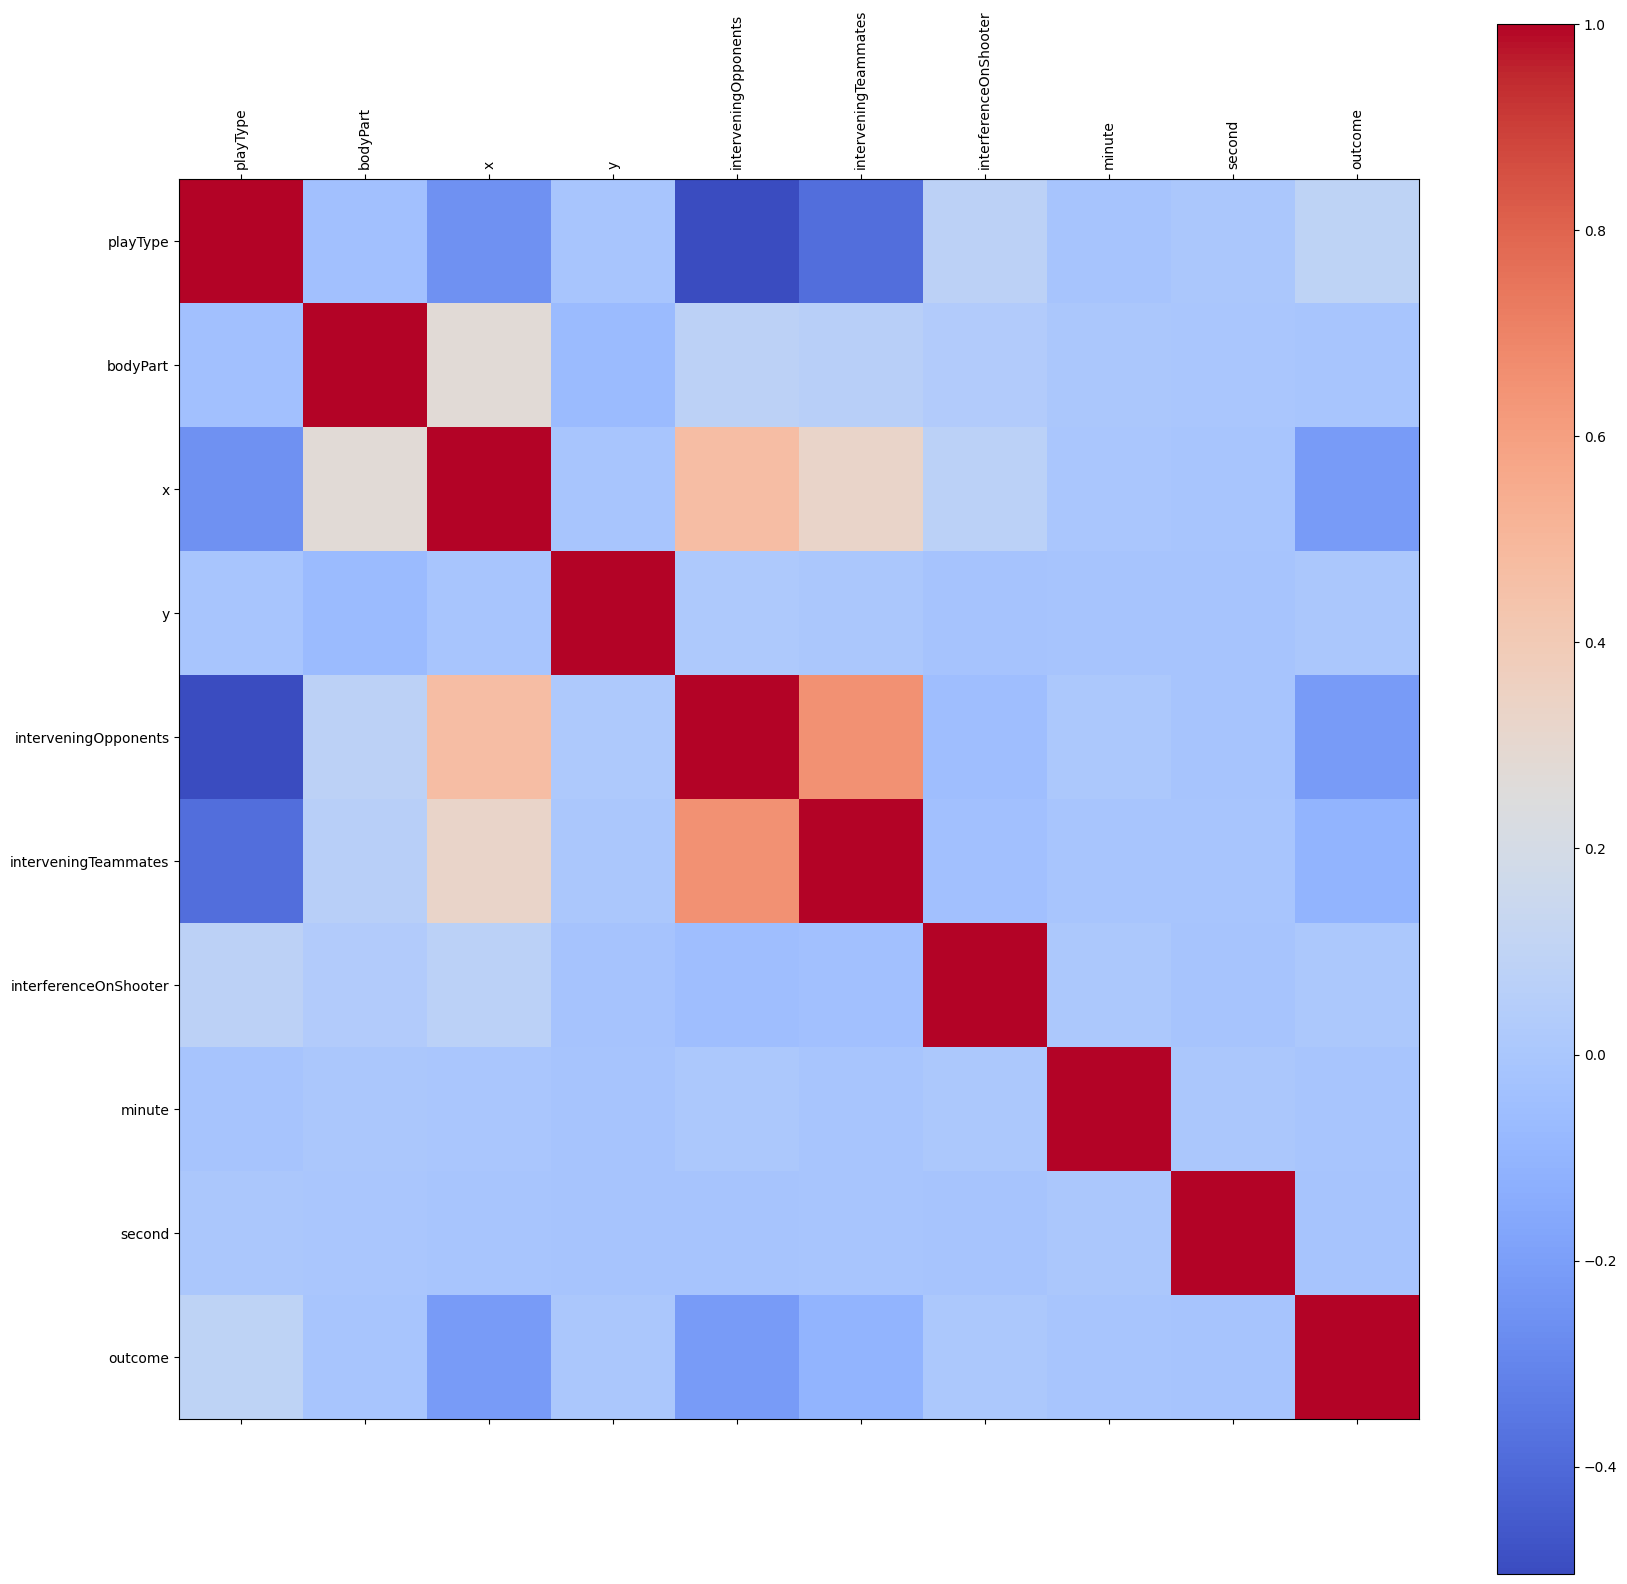

In [193]:
plt.figure(figsize=(20, 20))
plt.matshow(clean_data.corr(), cmap='coolwarm', fignum=1)
plt.colorbar()
plt.xticks(range(len(clean_data.columns)), clean_data.columns, rotation='vertical')
plt.yticks(range(len(clean_data.columns)), clean_data.columns)
plt.show()

In [194]:
correlation = clean_data.corr()
correlation['outcome'].sort_values(ascending=False)

outcome                  1.000000
playType                 0.089883
interferenceOnShooter    0.008075
y                        0.001947
minute                  -0.006726
bodyPart                -0.008928
second                  -0.012555
interveningTeammates    -0.101162
interveningOpponents    -0.213680
x                       -0.216209
Name: outcome, dtype: float64

In [195]:
X = clean_data.drop(columns=['outcome'])
y = clean_data['outcome']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)


(7112, 9) (7112,)
(1779, 9) (1779,)


In [196]:
model = RandomForestClassifier()
model.fit(X_train, y_train)

RandomForestClassifier()

In [197]:
y_train_pred = model.predict(X_test)

In [198]:
test_accuracy = accuracy_score(y_test, y_train_pred)
print(f"Accuracy: {test_accuracy}\n")

print("Confusion Matrix")
# [[true_positive, false_negative],
# [false_positive, true_negative]]
conf_matrix = confusion_matrix(y_test, y_train_pred)
print(conf_matrix, "\n")

print("Classification Report")
class_report = classification_report(y_test, y_train_pred)
print(class_report)

Accuracy: 0.8915120854412592

Confusion Matrix
[[1544   20]
 [ 173   42]] 

Classification Report
              precision    recall  f1-score   support

           0       0.90      0.99      0.94      1564
           1       0.68      0.20      0.30       215

    accuracy                           0.89      1779
   macro avg       0.79      0.59      0.62      1779
weighted avg       0.87      0.89      0.86      1779



## Analyzing the results With Feature Engineering

In [199]:
# radical x^2 + y^2
clean_data['distance'] = np.sqrt(clean_data['x']**2 + clean_data['y']**2)

# (using rad2deg(atan(theta))) where theta = 7.32x / (x^2 + y^2 - (7.32/2)^2)
clean_data['shot_angle'] = np.rad2deg(np.arctan(7.32 * clean_data['x'] / (clean_data['x']**2 + clean_data['y']**2 - (7.32/2)**2)))

clean_data

,playType,bodyPart,x,y,interveningOpponents,interveningTeammates,interferenceOnShooter,minute,second,outcome,distance,shot_angle
0,2,3,13.47,-11.22,1,0,2,70,9,1,17.530810,18.544088
1,2,1,9.48,14.22,3,0,2,55,4,0,17.090313,13.982592
2,0,1,29.43,-1.25,6,2,1,86,31,0,29.456534,14.153255
3,2,3,26.93,1.00,4,1,2,77,2,0,26.948560,15.458384
4,2,3,10.72,5.24,2,0,2,76,46,1,11.932141,31.315918
...,...,...,...,...,...,...,...,...,...,...,...,...
8920,2,0,6.48,3.99,3,0,0,69,50,0,7.609895,46.818116
8921,2,3,21.45,-8.73,4,1,2,15,53,0,23.158484,16.713121
8922,2,1,11.97,3.24,3,0,2,84,34,0,12.400746,31.970470
8923,2,3,6.48,-6.98,1,0,0,4,39,0,9.524222,31.529506


In [200]:
clean_data = clean_data.drop(columns=['x','y'])

clean_data_without_time = clean_data.drop(columns=['minute','second'])
clean_data

,playType,bodyPart,interveningOpponents,interveningTeammates,interferenceOnShooter,minute,second,outcome,distance,shot_angle
0,2,3,1,0,2,70,9,1,17.530810,18.544088
1,2,1,3,0,2,55,4,0,17.090313,13.982592
2,0,1,6,2,1,86,31,0,29.456534,14.153255
3,2,3,4,1,2,77,2,0,26.948560,15.458384
4,2,3,2,0,2,76,46,1,11.932141,31.315918
...,...,...,...,...,...,...,...,...,...,...
8920,2,0,3,0,0,69,50,0,7.609895,46.818116
8921,2,3,4,1,2,15,53,0,23.158484,16.713121
8922,2,1,3,0,2,84,34,0,12.400746,31.970470
8923,2,3,1,0,0,4,39,0,9.524222,31.529506


In [201]:
X_time = clean_data.drop(columns=['outcome'])
y_time = clean_data['outcome']

X_train_time, X_test_time, y_train_time, y_test_time = train_test_split(X_time, y_time, test_size=0.2, random_state=42)

model_time = RandomForestClassifier()
model_time.fit(X_train_time, y_train_time)

y_pred_time = model_time.predict(X_test_time)

accuracy_time = accuracy_score(y_test_time, y_pred_time)
print(f"Accuracy: {accuracy_time}\n")

conf_matrix_time = confusion_matrix(y_test_time, y_pred_time)
print(conf_matrix_time, "\n")

class_report_time = classification_report(y_test_time, y_pred_time)
print(class_report_time)

Accuracy: 0.8915120854412592

[[1536   28]
 [ 165   50]] 

              precision    recall  f1-score   support

           0       0.90      0.98      0.94      1564
           1       0.64      0.23      0.34       215

    accuracy                           0.89      1779
   macro avg       0.77      0.61      0.64      1779
weighted avg       0.87      0.89      0.87      1779



In [202]:
X_without_time = clean_data_without_time.drop(columns=['outcome'])
y_without_time = clean_data_without_time['outcome']

X_train_without_time, X_test_without_time, y_train_without_time, y_test_without_time = train_test_split(X_without_time, y_without_time, test_size=0.2, random_state=42)

model_without_time = RandomForestClassifier()
model_without_time.fit(X_train_without_time, y_train_without_time)

y_pred_without_time = model_without_time.predict(X_test_without_time)

accuracy_without_time = accuracy_score(y_test_without_time, y_pred_without_time)
print(f"Accuracy: {accuracy_without_time}\n")

conf_matrix_without_time = confusion_matrix(y_test_without_time, y_pred_without_time)
print(conf_matrix_without_time, "\n")

class_report_without_time = classification_report(y_test_without_time, y_pred_without_time)
print(class_report_without_time)


Accuracy: 0.8791455874086566

[[1504   60]
 [ 155   60]] 

              precision    recall  f1-score   support

           0       0.91      0.96      0.93      1564
           1       0.50      0.28      0.36       215

    accuracy                           0.88      1779
   macro avg       0.70      0.62      0.65      1779
weighted avg       0.86      0.88      0.86      1779



In [203]:
correlation = clean_data.corr()
correlation['outcome'].sort_values(ascending=False)

outcome                  1.000000
shot_angle               0.128599
playType                 0.089883
interferenceOnShooter    0.008075
minute                  -0.006726
bodyPart                -0.008928
second                  -0.012555
interveningTeammates    -0.101162
interveningOpponents    -0.213680
distance                -0.260733
Name: outcome, dtype: float64

<br><br><br>
2. **Multivariate Regression Implementation**

Implement multivariate regression from scratch and use the gradient descent
algorithm to update the weights. Validate the regression model by providing a visual
comparison between the predicted and actual values for “Price in Thousands” and
“Horsepower”. Additionally, plot the accuracy across different random states for a
more robust verification. Finally, display a learning curve to illustrate the progression
of the regression process.

In [6]:
cars_data = pd.read_csv("cars.csv")
cars_data

,Sales in Thousands,Year Resale Value,Price in Thousands,Engine Size,Horsepower,Wheelbase,Width,Length,Curb Weight,Fuel Capacity,Fuel Efficiency,Power Perf Factor,Vehicle Type Car,Vehicle Type Passenger
0,16.919,16.360,21.500,1.8,140,101.2,67.3,172.4,2.639,13.2,28,58.280150,0,1
1,39.384,19.875,28.400,3.2,225,108.1,70.3,192.9,3.517,17.2,25,91.370778,0,1
2,20.397,22.255,23.990,1.8,150,102.6,68.2,178.0,2.998,16.4,27,62.777639,0,1
3,18.780,23.555,33.950,2.8,200,108.7,76.1,192.0,3.561,18.5,22,84.565105,0,1
4,91.561,12.475,21.975,3.1,175,109.0,72.7,194.6,3.368,17.5,25,71.181451,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,9.761,11.425,14.900,2.0,115,98.9,68.3,163.3,2.767,14.5,26,46.943877,0,1
96,83.721,13.240,16.700,2.0,115,98.9,68.3,172.3,2.853,14.5,26,47.638237,0,1
97,51.102,16.725,21.200,1.8,150,106.4,68.5,184.1,3.043,16.4,27,61.701381,0,1
98,9.569,16.575,19.990,2.0,115,97.4,66.7,160.4,3.079,13.7,26,48.907372,0,1


As you can see below, there aren't any null value in this dataset because it is preprocessed.

In [7]:
cars_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 14 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Sales in Thousands      100 non-null    float64
 1   Year Resale Value       100 non-null    float64
 2   Price in Thousands      100 non-null    float64
 3   Engine Size             100 non-null    float64
 4   Horsepower              100 non-null    int64  
 5   Wheelbase               100 non-null    float64
 6   Width                   100 non-null    float64
 7   Length                  100 non-null    float64
 8   Curb Weight             100 non-null    float64
 9   Fuel Capacity           100 non-null    float64
 10  Fuel Efficiency         100 non-null    int64  
 11  Power Perf Factor       100 non-null    float64
 12  Vehicle Type Car        100 non-null    int64  
 13  Vehicle Type Passenger  100 non-null    int64  
dtypes: float64(10), int64(4)
memory usage: 11.1

In [185]:
from sklearn.metrics import mean_squared_error, r2_score

We split the dataset into 2 parts:
1. all columns except 'Horsepower' and 'Price in Thousands'
2. 'Horsepower' and 'Price in Thousands' columns

In [265]:
X = cars_data.drop(['Horsepower', 'Price in Thousands'], axis=1)
y = cars_data[['Horsepower', 'Price in Thousands']] 

Normalize the data:

In [266]:
X_norm = (X - X.mean()) / X.std()
y_norm = (y - y.mean()) / y.std() 

Add a column of ones to the independent variables to account for the intercept. In multivariate regression, the mathematical equation for the model is:

**y = b0 + b1x1 + b2x2 + ... + bn*xn**

The modified mathematical equation for the model is:

**y = b0x0 + b1x1 + b2x2 + ... + bnxn** <br>
(x0 is the intercept or bias feature with a constant value of 1)

By including the intercept or bias feature in the model, we can estimate the value of the intercept or bias term, b0, using the same method as for the other regression coefficients or weights. This allows us to account for the baseline or starting point of the model and improve its accuracy and interpretability.

In [267]:
X_norm = np.hstack((np.ones((X_norm.shape[0], 1)), X_norm))

In [268]:
def calculate_r2_score(y_train, y_train_pred, y_test, y_test_pred, train_accuracies, test_accuracies):
	train_accuracy = r2_score(y_train, y_train_pred)
	train_accuracies.append(train_accuracy)
	test_accuracy = r2_score(y_test, y_test_pred)
	test_accuracies.append(test_accuracy)

In [269]:
def calculate_mean_squared_error(y_train, y_train_pred, y_test, y_test_pred, train_errors, test_errors):
	train_error = mean_squared_error(y_train, y_train_pred)
	train_errors.append(train_error)
	test_error = mean_squared_error(y_test, y_test_pred)
	test_errors.append(test_error)

In [270]:
X_train, X_test, y_train, y_test = train_test_split(X_norm, y_norm, test_size=0.3, 
													random_state=42)

In [271]:
weights = np.zeros((X_train.shape[1], y_train.shape[1])) 
learning_rate = 0.01 
num_iterations = 1000

In [272]:
test_accuracies, train_accuracies, test_errors, train_errors = [], [], [], []

def multivariate_regression(weights, X_train, X_test, y_train, y_test):
	for j in range(num_iterations):
		y_train_pred = np.dot(X_train, weights)
		y_test_pred = np.dot(X_test, weights)
		error = y_train_pred - y_train
		gradient = np.dot(X_train.T, error) / X_train.shape[0]
		weights -= learning_rate * gradient
		calculate_r2_score(y_train, y_train_pred, y_test, y_test_pred, train_accuracies, test_accuracies)
		calculate_mean_squared_error(y_train, y_train_pred, y_test, y_test_pred, train_errors, test_errors)
	return weights
  
weights = multivariate_regression(weights, X_train, X_test, y_train, y_test)

Display a learning curve to illustrate the progression
of the regression process:

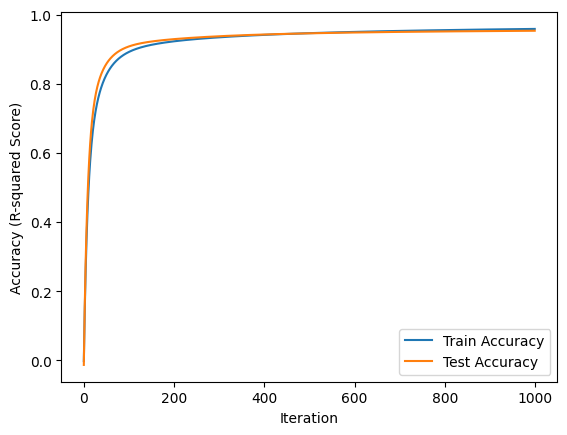

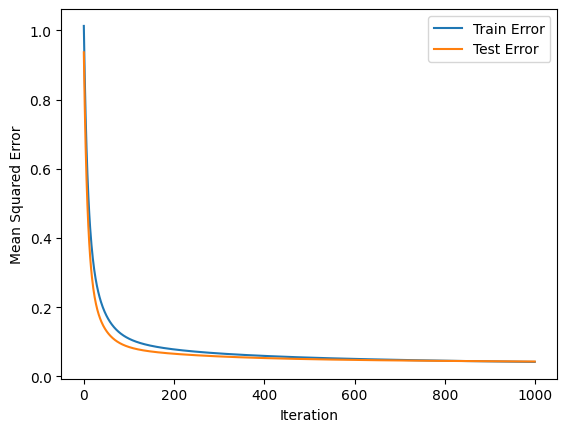

In [273]:
plt.plot(range(num_iterations), train_accuracies, label='Train Accuracy')
plt.plot(range(num_iterations), test_accuracies, label='Test Accuracy')
plt.xlabel('Iteration')
plt.ylabel('Accuracy (R-squared Score)')
plt.legend()
plt.show()

plt.plot(range(num_iterations), train_errors, label='Train Error')
plt.plot(range(num_iterations), test_errors, label='Test Error')
plt.xlabel('Iteration')
plt.ylabel('Mean Squared Error')
plt.legend()
plt.show()

Provide a visual
comparison between the predicted and actual values:

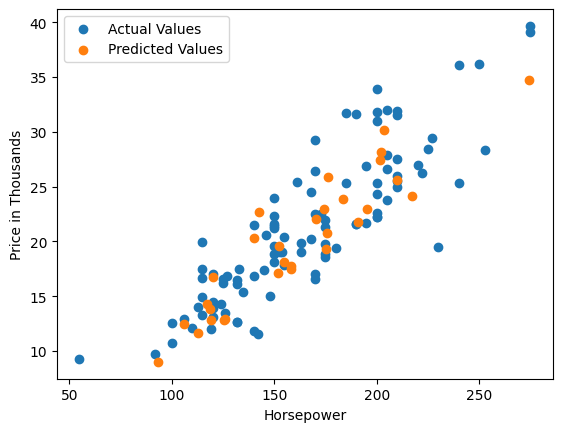

In [274]:
y_train_pred = np.dot(X_train, weights) 
y_test_pred = np.dot(X_test, weights)

plt.scatter(cars_data['Horsepower'], cars_data['Price in Thousands'], label='Actual Values')
plt.scatter(y_test_pred[:, 0] * y['Horsepower'].std() + y['Horsepower'].mean(), y_test_pred[:, 1] * y['Price in Thousands'].std() + y['Price in Thousands'].mean(), label='Predicted Values')
plt.xlabel('Horsepower')
plt.ylabel('Price in Thousands')
plt.legend()
plt.show()

Plot the accuracy across different random states for a
more robust verification:

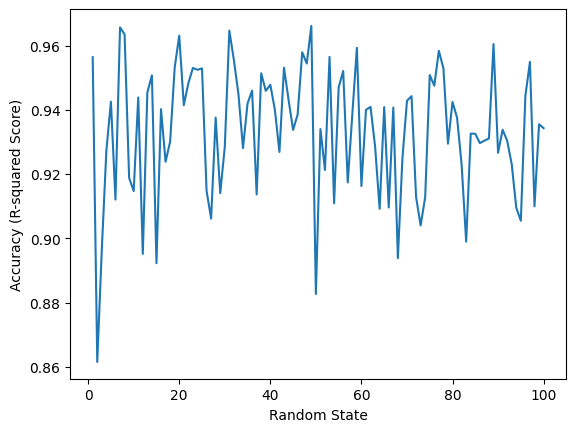

In [166]:
accuracies = []
num_states = 100

for i in range(num_states):
	X_train, X_test, y_train, y_test = train_test_split(X_norm, y_norm, test_size=0.3, random_state=i)
	weights = np.zeros((X_train.shape[1], y_train.shape[1]))
	weights = multivariate_regression(weights, X_train, X_test, y_train, y_test)
	y_test_pred = np.dot(X_test, weights)
	accuracy = r2_score(y_test, y_test_pred)
	accuracies.append(accuracy)

plt.plot(range(1, num_states+1), accuracies)
plt.xlabel('Random State')
plt.ylabel('Accuracy (R-squared Score)')
plt.show()



In [275]:
print(f"model's train R2 Score is: {r2_score(y_train_pred, y_train)}")
print(f"model's test R2 Score is: {r2_score(y_test_pred, y_test)}")
print(f"model's train Mean Squared Error is: {mean_squared_error(y_train_pred, y_train)}")
print(f"model's test Mean Squared Error is: {mean_squared_error(y_test_pred, y_test)}")

model's train R2 Score is: 0.9547729274814791
model's test R2 Score is: 0.9457493631335296
model's train Mean Squared Error is: 0.04208189515233436
model's test Mean Squared Error is: 0.043235074101684645


<br><br><br>
3. **Manual K-Fold Cross Validation Implementation**

Implement K-Fold cross-validation from scratch. As in the previous section, use the
gradient descent algorithm to adjust the weights. Then, validate your custom K-Fold
implementation using statistical metrics. Finally, display a learning curve upon
completion.

In [276]:
X = X.values
y = y.values

1's fold's R2 Score is: 0.5702484835502724
1's fold's Mean Squared Error is: 0.045037261053392764


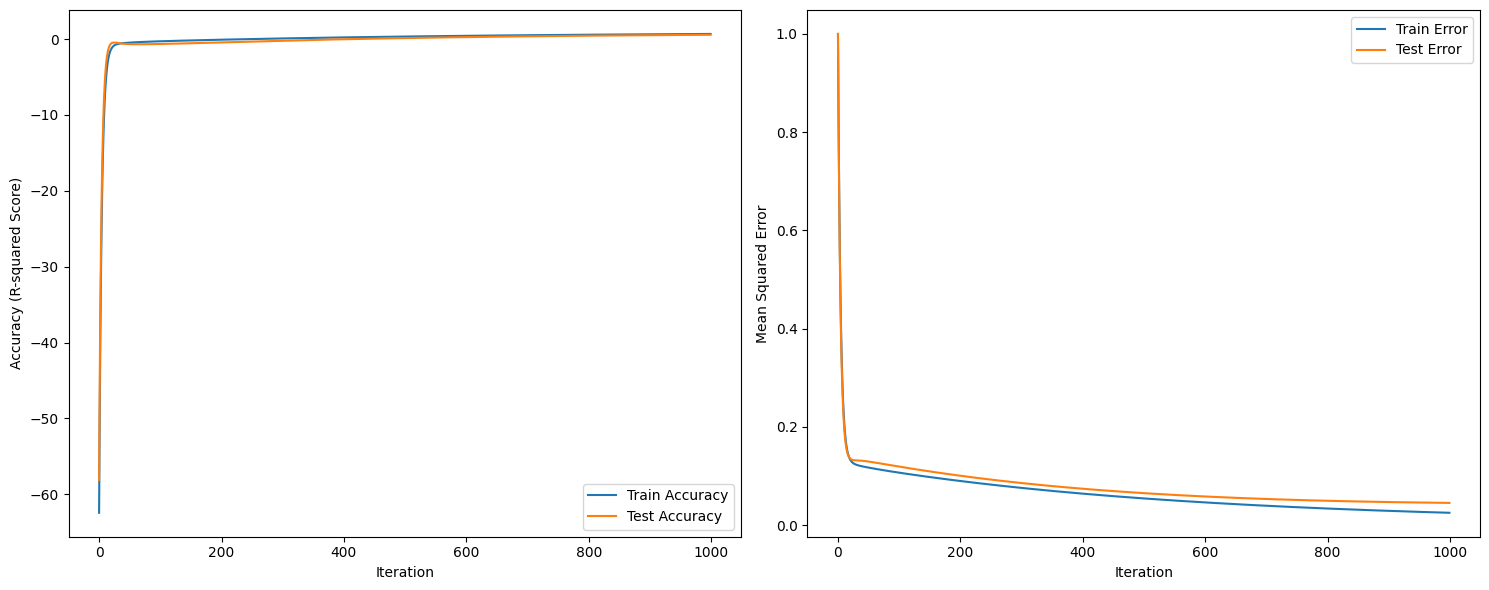

2's fold's R2 Score is: 0.08881778610006008
2's fold's Mean Squared Error is: 0.06057847791368287


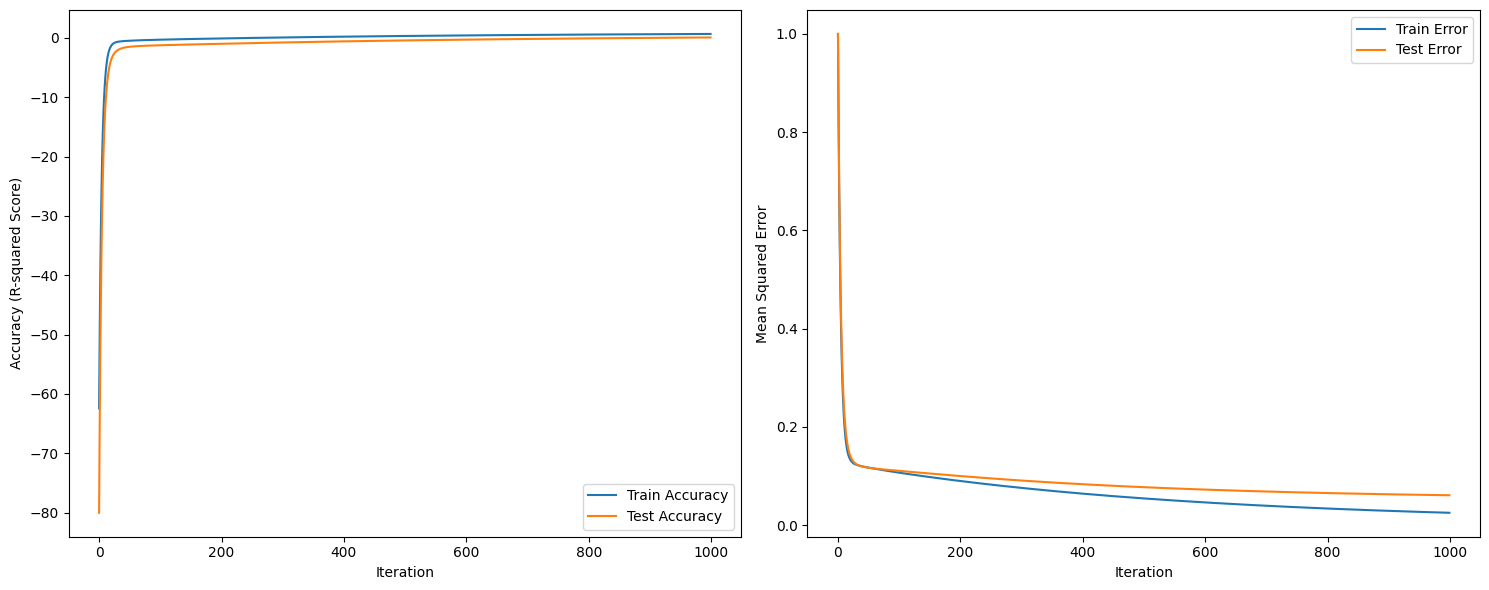

3's fold's R2 Score is: 0.7707572447129534
3's fold's Mean Squared Error is: 0.016987511047533262


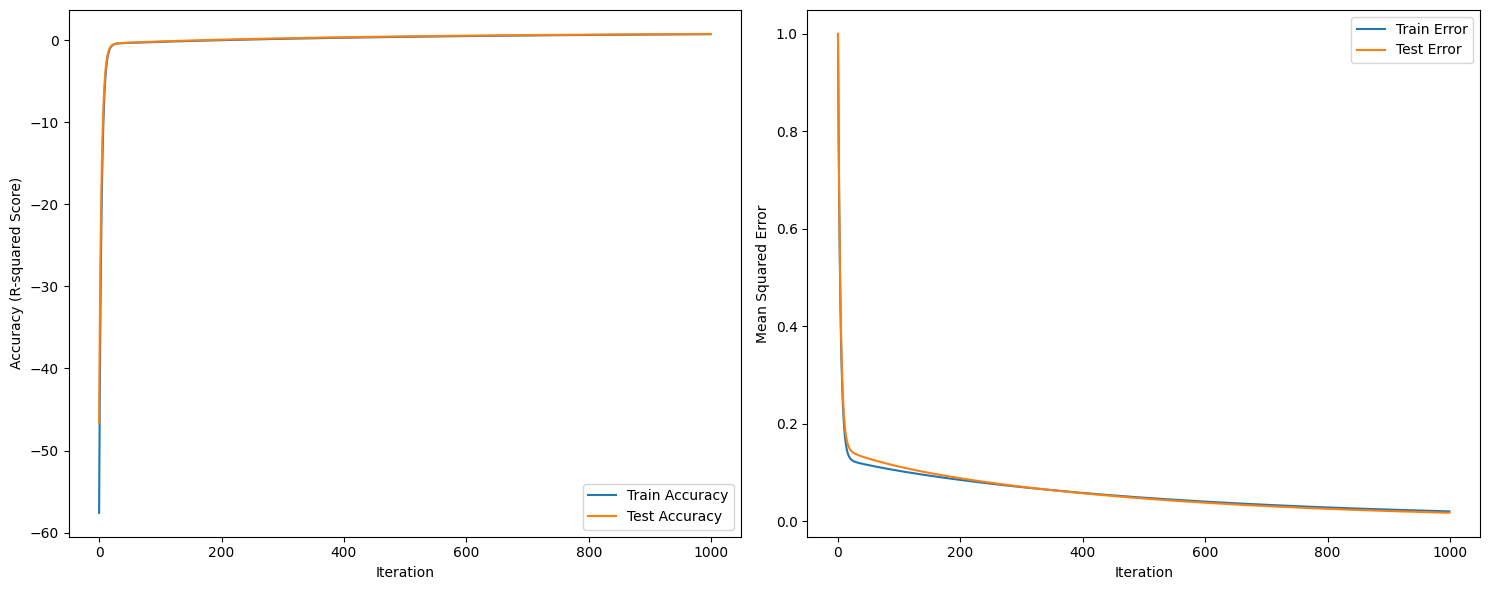

4's fold's R2 Score is: 0.6507362289486631
4's fold's Mean Squared Error is: 0.024465144072160553


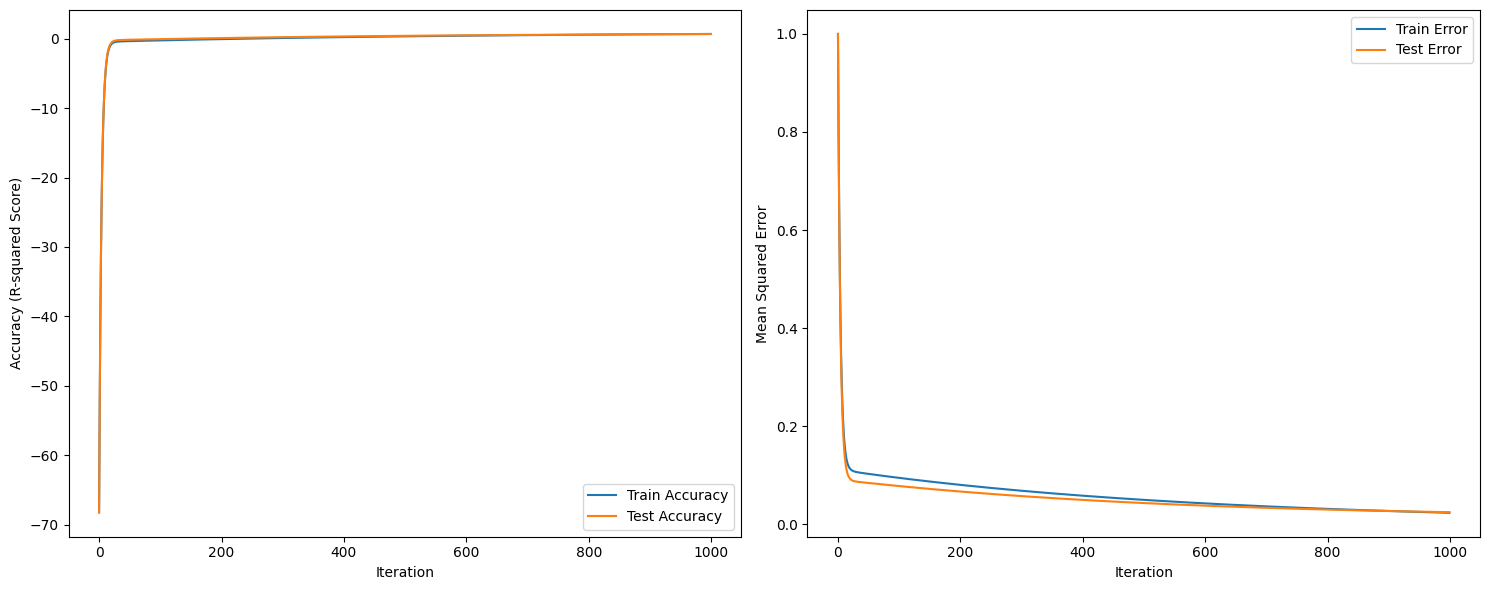

5's fold's R2 Score is: 0.5553831838370825
5's fold's Mean Squared Error is: 0.02753525474261002


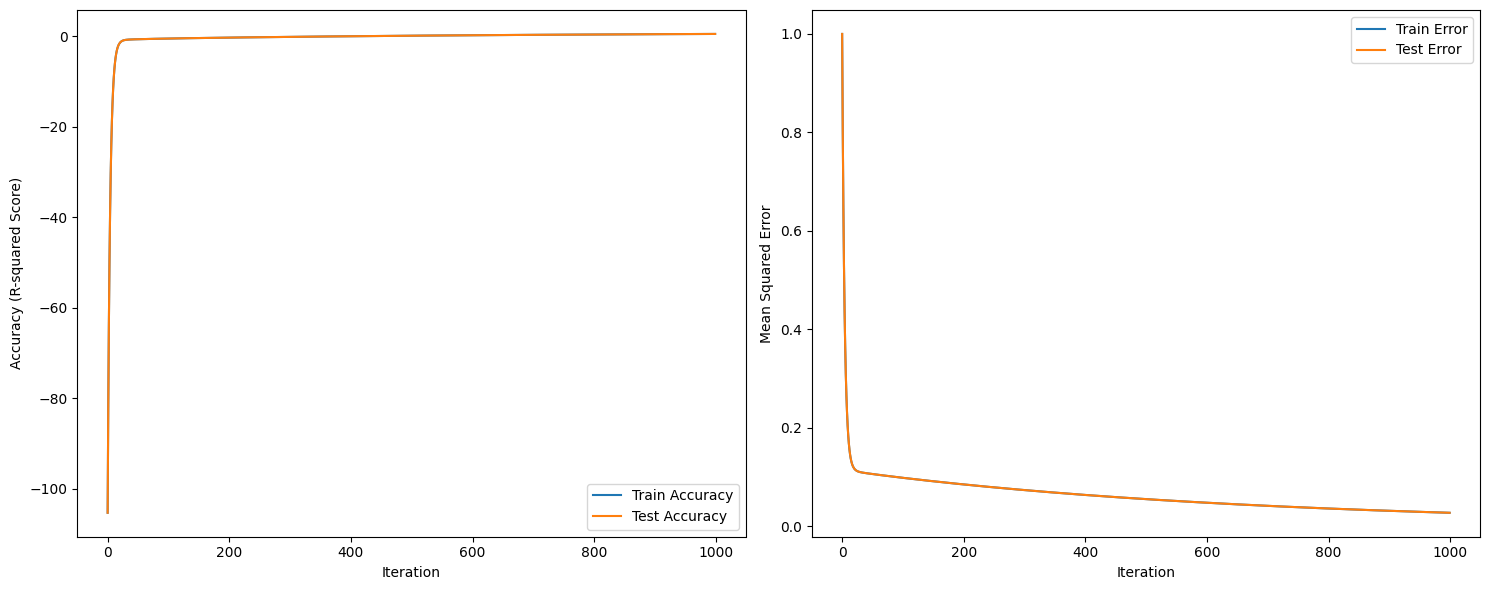

Average training R2 Score: 0.663729646184757
Average testing R2 Score: 0.5271885854298063
Average training mean squared error: 0.024085195172121612
Average testing mean squared error: 0.03492072976587589


In [277]:
k = 5

all_folds_train_r2_scores, all_folds_test_r2_scores, all_folds_train_mean_squared_errors, all_folds_test_mean_squared_errors = [], [], [], []

# Split the data into k folds
fold_size = X.shape[0] // k
for i in range(k):
	train_accuracies, test_accuracies, train_errors, test_errors = [], [], [], []

	test_start = i * fold_size
	test_end = test_start + fold_size
	X_test = X[test_start:test_end]
	y_test = y[test_start:test_end]

	train_start = 0
	train_end = test_start if i > 0 else test_end
	X_train = np.concatenate((X[:train_start], X[train_end:]))
	y_train = np.concatenate((y[:train_start], y[train_end:]), axis=0)

	X_train_norm = (X_train - X_train.mean()) / X_train.std()
	X_test_norm = (X_test - X_test.mean()) / X_test.std()
	y_train_norm = (y_train - y_train.mean()) / y_train.std()
	y_test_norm = (y_test - y_test.mean()) / y_test.std()

	X_train_norm = np.hstack((np.ones((X_train_norm.shape[0], 1)), X_train_norm))
	X_test_norm = np.hstack((np.ones((X_test_norm.shape[0], 1)), X_test_norm))

	weights = np.zeros((X_train_norm.shape[1], y_train_norm.shape[1]))

	weights = multivariate_regression(weights, X_train_norm, X_test_norm, y_train_norm, y_test_norm)
	
	y_train_pred = np.dot(X_train_norm, weights)
	y_test_pred = np.dot(X_test_norm, weights)
	r2_score_test = r2_score(y_test_norm, y_test_pred)
	mean_squared_error_test = mean_squared_error(y_test_norm, y_test_pred)
	r2_score_train = r2_score(y_train_norm, y_train_pred)
	mean_squared_error_train = mean_squared_error(y_train_norm, y_train_pred)
	print(f"{i+1}'s fold's R2 Score is: {r2_score_test}")
	print(f"{i+1}'s fold's Mean Squared Error is: {mean_squared_error_test}")

	plt.figure(figsize=(15, 6))

	plt.subplot(1, 2, 1)
	plt.plot(range(num_iterations), train_accuracies, label='Train Accuracy')
	plt.plot(range(num_iterations), test_accuracies, label='Test Accuracy')
	plt.xlabel('Iteration')
	plt.ylabel('Accuracy (R-squared Score)')
	plt.legend()

	plt.subplot(1, 2, 2)
	plt.plot(range(num_iterations), train_errors, label='Train Error')
	plt.plot(range(num_iterations), test_errors, label='Test Error')
	plt.xlabel('Iteration')
	plt.ylabel('Mean Squared Error')
	plt.legend()
 
	plt.tight_layout()
	plt.show()
 
	all_folds_train_r2_scores.append(r2_score_train)
	all_folds_test_r2_scores.append(r2_score_test)
	all_folds_train_mean_squared_errors.append(mean_squared_error_train)
	all_folds_test_mean_squared_errors.append(mean_squared_error_test)

avg_train_accuracy = np.mean(all_folds_train_r2_scores)
avg_test_accuracy = np.mean(all_folds_test_r2_scores)
avg_train_error = np.mean(all_folds_train_mean_squared_errors)
avg_test_error = np.mean(all_folds_test_mean_squared_errors)

print('Average training R2 Score:', avg_train_accuracy)
print('Average testing R2 Score:', avg_test_accuracy)
print('Average training mean squared error:', avg_train_error)
print('Average testing mean squared error:', avg_test_error)


<br><br><br>
4. **Comparison with Built-in Python Libraries**

Now, compare the results from your custom implementations in sections 2 and 3 with
those obtained using built-in Python libraries, and report the findings.



We saw the r2 scores and mean squared errors at the end of each task

# Questions

### 1. Describe your strategy for addressing challenges such as handling missing values and categorical features. Could you also elaborate on your feature selection metrics and explain the rationale behind them?
My approach involves handling missing values by imputing them using statistical methods or deleting them if necessary. For categorical features, I encode them using techniques like one-hot encoding or label encoding. For feature selection, I use metrics like correlation, feature importance scores, or domain knowledge to choose the most relevant features. The goal is to enhance model performance and interpretability.


### 2. Why didn’t we use regression to predict whether a shot would result in a goal?
Because regression models are typically used for predicting continuous outcomes, such as predicting the price of a house or the temperature. In the case of predicting whether a shot would result in a goal, the outcome is binary (goal or no goal), making it a classification problem rather than a regression problem. Therefore, it's more appropriate to use classification algorithms such as logistic regression, decision trees, or random forests, which are specifically designed for predicting categorical outcomes. These models can provide probabilities or class labels indicating whether a shot is likely to result in a goal or not.


### 3. How would you go about verifying the accuracy of the given formula used to calculate the shot angle in the preprocessing section?
To verify the accuracy of the given formula for calculating the shot angle, we would implement the correct formula angle = arctan(y/x) to calculate the shot angle. I can test it on simple cases where I can manually calculate the expected angle. If real-world data with recorded angles is available, I would compare the calculated angles with that data. I would also visualize the shot locations and angles on a pitch diagram to check if they seem reasonable. Handling edge cases like shots from the goal line or center correctly would be important. If possible, I would consult domain experts or literature for cross-verification.

### 4. Discuss the advantages and disadvantages of k-fold cross-validation. Can you also explain other types of cross-validation methods that could address the limitations and issues associated with k-fold cross-validation? <br>

**Advantages of k-fold cross-validation:**

- It provides a more reliable estimation of model performance compared to other cross-validation methods such as train-test split. This is because k-fold cross-validation uses all available data for both training and testing, which helps to reduce the bias and variance in the model's performance estimate.

- It allows for efficient use of data, especially when the dataset is small. By using k-1 folds for training and one fold for testing, k-fold cross-validation ensures that the model is trained on as much data as possible while still providing an unbiased estimate of its performance.

- It is easy to implement and understand, making it a popular choice for evaluating machine learning models.


**Disadvantages of k-fold cross-validation:**

- It can be computationally expensive, especially for large datasets or complex models. This is because k-fold cross-validation requires training and testing the model k times, which can be time-consuming.
- It assumes that the data is evenly distributed across the folds, which may not always be the case. If the data is not evenly distributed, then some folds may be more difficult to predict than others, leading to biased performance estimates.
- It is sensitive to the choice of k. If k is too small, then the performance estimate may be biased due to the limited amount of data used for testing. If k is too large, then the performance estimate may have high variance due to the small number of samples in each fold.


**Other types of cross-validation methods that could address the limitations and issues associated with k-fold cross-validation include:**

- **Stratified k-fold cross-validation:** This method is a variant of k-fold cross-validation that ensures that each fold has approximately the same proportion of samples from each class as the original dataset. This can help to reduce bias in the performance estimate, especially for imbalanced datasets.
- **Leave-one-out cross-validation (LOOCV):** This method involves training the model on all but one sample and testing it on the left-out sample. This process is repeated for each sample in the dataset. LOOCV provides an unbiased estimate of model performance, but it can be computationally expensive for large datasets.
- **Leave-p-out cross-validation:** This method is a generalization of LOOCV that involves leaving out p samples instead of one. This can be useful when the dataset is small and LOOCV is too computationally expensive.
- **Repeated k-fold cross-validation:** This method involves repeating k-fold cross-validation multiple times with different random splits of the data. This can help to reduce the variance in the performance estimate, especially for small datasets.
- **Time-series cross-validation:** This method is used for time-series data and involves splitting the data into training and testing sets based on time. For example, the model could be trained on data from the first n months and tested on data from the (n+1)th month. This process is repeated for each month in the dataset. Time-series cross-validation can help to ensure that the model is not overfitting to trends in the data.



### 5. What metrics did you use to evaluate your manual implementations of multivariate regression and k-fold cross-validation, and why did you choose them? <br>

R2 score and mean squared error because we wanted to see the accuracy and loss of out model.